# 1. Data Loading

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('/kaggle/input/nf-uq-nids-v2-sample/NF-UQ-NIDS-V2-Sample.csv')

In [ ]:
#df1 = pd.DataFrame(df.get_chunk(500000))
df1 = df
#loading only small chunk to save space

In [ ]:
df1.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset,Attack_Class
0,192.168.100.148,65389,192.168.100.7,80,6,7.0,420,3,0,0,...,35840,140,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2,DoS/DDoS
1,192.168.100.148,11154,192.168.100.5,80,6,7.0,280,2,40,1,...,0,0,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2,DoS/DDoS
2,192.168.1.31,42062,192.168.1.79,1041,6,0.0,44,1,40,1,...,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2,Benign
3,192.168.1.34,46849,192.168.1.79,9110,6,0.0,44,1,40,1,...,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2,Benign
4,192.168.1.30,50360,192.168.1.152,1084,6,0.0,44,1,40,1,...,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2,Benign


In [ ]:
print(len(df1['Attack_Class'].unique()))
unique_counts = df1.groupby('Attack_Class').size()
print(unique_counts)

11
Attack_Class
Benign              503313
Botnet                2864
Brute Force           2480
DoS/DDoS            792499
MITM                   133
Malware                778
Password             23062
Phishing            131175
SQL Injection        13702
XSS                  49105
Zero Day Exploit       649
dtype: int64


# 2. Data Transformation

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
LE = LabelEncoder()

#ip addresses are in format xxx.xxx.xxx.xxx which is not compatible with the models
srcaddr= LE.fit_transform(df1['IPV4_SRC_ADDR'])
df1['IPV4_SRC_ADDR'] = pd.Series(srcaddr)
dstaddr= LE.fit_transform(df1['IPV4_DST_ADDR'])
df1['IPV4_DST_ADDR'] = pd.Series(dstaddr)
del srcaddr,dstaddr # Delete variables no longer needed


In [ ]:
def reduce_attack_class(classCol, flag):
    mapping = {
            'Benign': 'Benign',
            'DoS': 'DoS/DDoS',
            'DDoS': 'DoS/DDoS',
            'scanning': 'Phishing',
            'Reconnaissance':'Phishing',
            'xss': 'XSS',
            'password': 'Password',
            'injection': 'SQL Injection',
            'Bot': 'Botnet',
            'Brute Force': 'Brute Force',
            'Infilteration': 'Phishing',
            'Exploits': 'Zero Day Exploit',
            'Fuzzers': 'Phishing',
            'Backdoor': 'Malware',
            'Generic': 'Malware',
            'mitm': 'MITM',
            'ransomware': 'Malware',
            'Analysis': 'Phishing',
            'Theft': 'Phishing',
            'Shellcode': 'Zero Day Exploit',
            'Worms': 'Malware',
           }

    if flag:
        return classCol.apply(lambda v: mapping[v])

    else:
        return classCol

In [ ]:
#df1['Attack_Class'] = reduce_attack_class(df1['Attack'],False)
#df1['Attack_Class'] = reduce_attack_class(df1['Attack'],True)

In [ ]:
X1 = df1.drop(['Attack','Label','Dataset','Attack_Class'], axis=1)
Y1 = df1["Attack_Class"]

# X1 = df1.drop(['Attack','Label','Dataset'], axis=1)
# Y1 = df1["Attack"]

In [ ]:
LE = LabelEncoder()
multilbl = LE.fit_transform(Y1)
Y1 = pd.Series(multilbl)

In [ ]:
from sklearn.impute import SimpleImputer 

In [ ]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

X1_object = X1.select_dtypes("object")
X1_int = X1.select_dtypes(exclude = "object")

X1_columns = X1_int.columns #this stores column names 

imputer.fit(X1_int)
X1_int = imputer.transform(X1_int)
X1_int = pd.DataFrame(X1_int)
X1_int.columns = X1_columns #corrects column name

X1_object = X1_object.fillna("unknown")
X1 = X1_object.join(X1_int)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
# store the columns
cols = X1.columns

# transform the data
X1_scaled = scaler.fit_transform(X1)

X1_scaled = pd.DataFrame(X1_scaled, columns = cols)

In [ ]:
# Access the original classes
classes = LE.classes_


# Print the mapping
for i, cls in enumerate(classes):

    print(f"{i}: {cls}")

0: Benign
1: Botnet
2: Brute Force
3: DoS/DDoS
4: MITM
5: Malware
6: Password
7: Phishing
8: SQL Injection
9: XSS
10: Zero Day Exploit


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import StratifiedKFold
def StratifiedSplit(X,Y,test_size):
    folds=int(1/test_size)
    sk=StratifiedKFold(n_splits=folds)
    X=pd.DataFrame(X)
    Y=pd.DataFrame(Y)
    # Initialize empty dataframes
    x_train = pd.DataFrame(columns=X.columns)
    y_train = pd.DataFrame(columns=Y.columns)
    x_test = pd.DataFrame(columns=X.columns)
    y_test = pd.DataFrame(columns=Y.columns)
    
    for train_index, test_index in skfolds.split(X, Y):
        x_train = pd.concat([x_train, X1.iloc[train_index]])
        y_train = pd.concat([y_train, Y1.iloc[train_index]])
        x_test = pd.concat([x_test, X1.iloc[test_index]])
        y_test = pd.concat([y_test, Y1.iloc[test_index]])
    return x_train, x_test, y_train, y_test

In [ ]:
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(Y1)

In [ ]:
X1_scaled = X1_scaled.values.reshape(X1_scaled.shape[0], X1_scaled.shape[1],1)

In [ ]:
x_train_dl, x_test_dl, y_train_dl, y_test_dl = train_test_split(X1_scaled, y_cat, test_size=0.2,random_state=42)
x_train_dl, x_val_dl, y_train_dl, y_val_dl = train_test_split(x_train_dl, y_train_dl, test_size=0.25,random_state=42)

# 3. Utils

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, Reshape, SimpleRNN, Flatten

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot

In [ ]:
# Define tand get the number os devices. 
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 1


In [ ]:
def plot_history(history):
    acc = history.history["accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    val_accuracy = history.history["val_accuracy"]
    
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="traning_acc")
    plt.plot(x, val_accuracy, "r", label="traning_acc")
    plt.title("Accuracy")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="traning_acc")
    plt.plot(x, val_loss, "r", label="traning_acc")
    plt.title("Loss")

In [ ]:
input_feature=x_train_dl.shape[1]
output_classes=len(y_train_dl[0])

# 3. Model : RNN-LSTM

## 3.1. Model Development

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
def LSTM_Model():
    model = Sequential([
        Input(shape=(input_feature,1)),
        LSTM(32, return_sequences=True),
        #Dropout(0.3),
        BatchNormalization(),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(64),
        Dense(output_classes, activation="softmax")
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
def LSTM_Model2():
    model = Sequential([
        Input(shape=(input_feature,1)),
        LSTM(32, return_sequences=True,recurrent_activation="tanh"),
        #Dropout(0.3),
        BatchNormalization(),
        LSTM(64, return_sequences=True,recurrent_activation="tanh"),
        Dropout(0.5),
        BatchNormalization(),
        LSTM(64,recurrent_activation="tanh"),
        Dense(output_classes, activation="softmax")
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
with strategy.scope():
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model = LSTM_Model()
    model2 = LSTM_Model2()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 43, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 43, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 43, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 43, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,307 (247.29 KB)

 Trainable params: 63,115 (246.54 KB)

 Non-trainable params: 192 (768.00 B)

## 3.2. Model training

### 3.2.1. Model1

In [ ]:
history = model.fit(x_train_dl ,y_train_dl, verbose=1, epochs=100, batch_size=256,validation_data=(x_val_dl,y_val_dl),callbacks=[early_stopping])

Epoch 1/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - accuracy: 0.8595 - loss: 0.4045 - val_accuracy: 0.9277 - val_loss: 0.2064
Epoch 2/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.9346 - loss: 0.1831 - val_accuracy: 0.9362 - val_loss: 0.1698
Epoch 3/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.9445 - loss: 0.1510 - val_accuracy: 0.9306 - val_loss: 0.2184
Epoch 4/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - accuracy: 0.9495 - loss: 0.1354 - val_accuracy: 0.9297 - val_loss: 0.1978
Epoch 5/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.9529 - loss: 0.1273 - val_accuracy: 0.8699 - val_loss: 0.4265
Epoch 6/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.9551 - loss: 0.1217 - val_accuracy: 0.8895 - val_loss: 0.3478
Epoch 7/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - accuracy: 0.9570 - loss: 0.1181 - val_accuracy: 0.3282 - val_loss: 3.4387
Epoch 8/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - accuracy: 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot

In [ ]:
mean = sum(history.history['accuracy']) / len(history.history['accuracy'])
variance = sum([((x - mean) ** 2) for x in history.history['accuracy']]) / len(history.history['accuracy'])
res = variance ** 0.5
print("Baseline: %.2f%% (%.2f%%)" % (mean*100, res*100))

Baseline: 96.65% (1.36%)


In [ ]:
y_pred = model.predict(x_test_dl)
y_pred_class = y_pred.argmax(axis=-1)
y_test_class = np.argmax(y_test_dl, axis=1)

print(classification_report(y_test_class, y_pred_class))

9499/9499 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    100316
           1       1.00      1.00      1.00       593
           2       0.99      0.98      0.99       494
           3       0.99      1.00      0.99    158629
           4       1.00      0.17      0.29        30
           5       0.92      0.78      0.84       160
           6       0.87      0.90      0.89      4638
           7       0.95      0.90      0.93     26316
           8       0.85      0.64      0.73      2817
           9       0.91      0.96      0.93      9830
          10       0.71      0.74      0.73       129

    accuracy                           0.98    303952
   macro avg       0.92      0.82      0.84    303952
weighted avg       0.98      0.98      0.98    303952



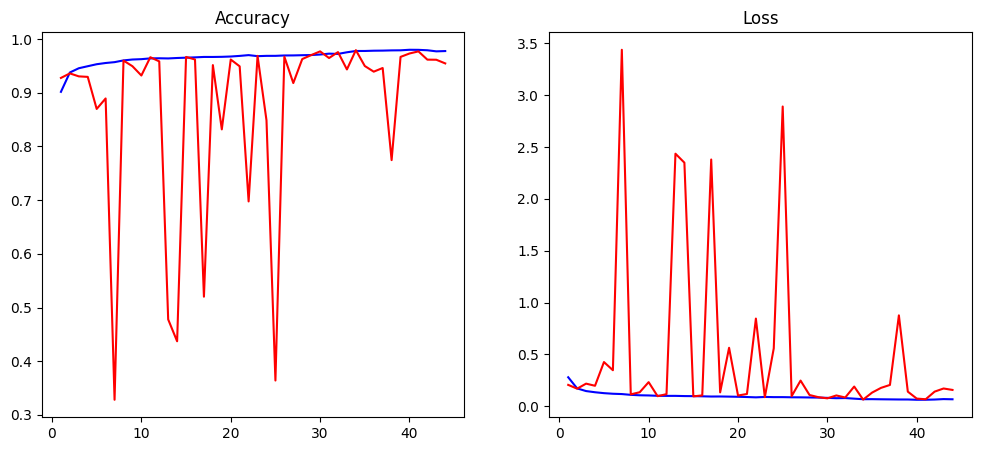

In [ ]:
plot_history(history)

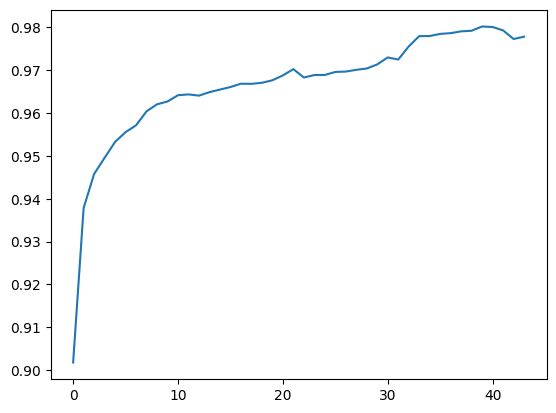

In [ ]:
pyplot.plot(history.history['accuracy'])
pyplot.savefig('DL_LSTM1_Accuracy_EpochVsAccuracy.jpg',dpi=900)
pyplot.show()

In [ ]:
loss, accuracy = model.evaluate(x_test_dl, y_test_dl)
print('Test Accuracy:', accuracy)

9499/9499 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.9791 - loss: 0.0656
Test Accuracy: 0.9789144396781921


# 4. Model : RNN

## 4.1. Model Development

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
input_feature=x_train_dl.shape[1]
output_classes=len(y_train_dl[0])

In [ ]:
def Simple_RNN_Model():
    model = Sequential([
        Input(shape=(input_feature,1)),
        SimpleRNN(32),
        Dense(output_classes, activation="softmax")
    ])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
with strategy.scope():
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model = Simple_RNN_Model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,451 (5.67 KB)

 Trainable params: 1,451 (5.67 KB)

 Non-trainable params: 0 (0.00 B)

## 4.2. Model Training

In [ ]:
history = model.fit(x_train_dl ,y_train_dl, verbose=1, epochs=100, batch_size=256,validation_data=(x_val_dl,y_val_dl),callbacks=[early_stopping])

Epoch 1/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 122s 34ms/step - accuracy: 0.8133 - loss: 0.6387 - val_accuracy: 0.8794 - val_loss: 0.3410
Epoch 2/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 120s 34ms/step - accuracy: 0.8922 - loss: 0.3108 - val_accuracy: 0.9000 - val_loss: 0.2804
Epoch 3/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 120s 34ms/step - accuracy: 0.9023 - loss: 0.2783 - val_accuracy: 0.9097 - val_loss: 0.2548
Epoch 4/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 120s 34ms/step - accuracy: 0.9082 - loss: 0.2579 - val_accuracy: 0.9090 - val_loss: 0.2592
Epoch 5/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 120s 34ms/step - accuracy: 0.9103 - loss: 0.2491 - val_accuracy: 0.9116 - val_loss: 0.2468
Epoch 6/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 120s 34ms/step - accuracy: 0.9138 - loss: 0.2371 - val_accuracy: 0.9164 - val_loss: 0.2235
Epoch 7/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 120s 34ms/step - accuracy: 0.9165 - loss: 0.2306 - val_accuracy: 0.9205 - val_loss: 0.2235
Epoch 8/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 120s 34ms/step - ac

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot

In [ ]:
mean = sum(history.history['accuracy']) / len(history.history['accuracy'])
variance = sum([((x - mean) ** 2) for x in history.history['accuracy']]) / len(history.history['accuracy'])
res = variance ** 0.5
print("Baseline: %.2f%% (%.2f%%)" % (mean*100, res*100))

Baseline: 94.43% (1.54%)


In [ ]:
y_pred = model.predict(x_test_dl)
y_pred_class = y_pred.argmax(axis=-1)
y_test_class = np.argmax(y_test_dl, axis=1)

print(classification_report(y_test_class, y_pred_class))

9499/9499 ━━━━━━━━━━━━━━━━━━━━ 163s 17ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98    100316
           1       0.99      1.00      0.99       593
           2       0.98      0.97      0.98       494
           3       0.99      0.98      0.99    158629
           4       0.00      0.00      0.00        30
           5       0.80      0.69      0.74       160
           6       0.60      0.77      0.68      4638
           7       0.90      0.93      0.92     26316
           8       0.55      0.32      0.41      2817
           9       0.66      0.82      0.73      9830
          10       0.65      0.50      0.56       129

    accuracy                           0.96    303952
   macro avg       0.74      0.72      0.72    303952
weighted avg       0.96      0.96      0.96    303952



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


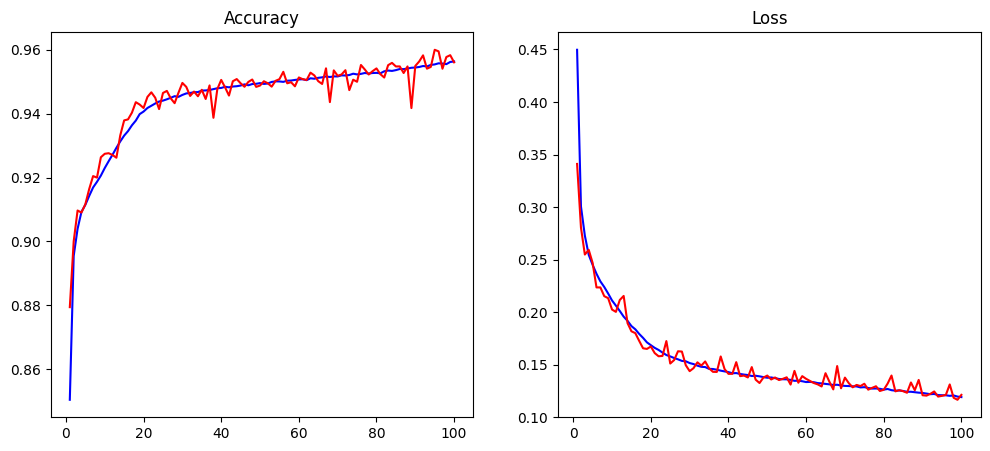

In [ ]:
plot_history(history)

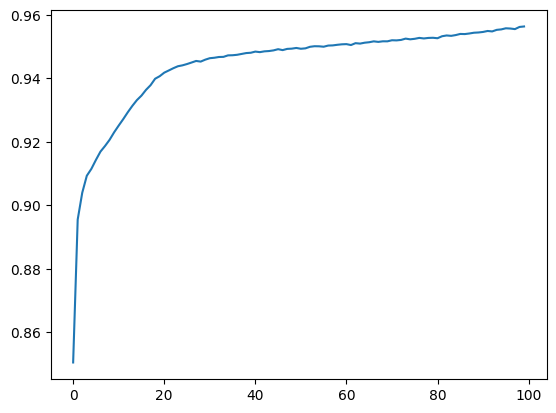

In [ ]:
pyplot.plot(history.history['accuracy'])
pyplot.savefig('DL_SRNN_Accuracy_EpochVsAccuracy.jpg',dpi=900)
pyplot.show()

In [ ]:
loss, accuracy = model.evaluate(x_test_dl, y_test_dl)
print('Test Accuracy:', accuracy)

9499/9499 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - accuracy: 0.9574 - loss: 0.1179
Test Accuracy: 0.9577630758285522


# 5. Model :CNN

## 5.1. Model Development

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
input_feature=x_train_dl.shape[1]
output_classes=len(y_train_dl[0])

In [ ]:
def CNN_Model():
    model = Sequential([
        Input(shape=(input_feature,1)),
        Dense(128, activation='relu'),
        Dense(64, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(16, activation = 'relu'),
        Flatten(),
        Dense(output_classes, activation="softmax")
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
with strategy.scope():
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model = CNN_Model()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 43, 128)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 43, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 43, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 688)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 11)             │         7,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,699 (73.04 KB)

 Trainable params: 18,699 (73.04 KB)

 Non-trainable params: 0 (0.00 B)

## 5.2. Model Training

In [ ]:

# Assuming df1 is your DataFrame
null_counts = df1.isnull().sum()
print("Null/NaN values per column:\n", null_counts)

# To check for NaN values only
nan_counts = df1.isna().sum()
print("\nNaN values per column:\n", nan_counts)

Null/NaN values per column:
 IPV4_SRC_ADDR                  0
L4_SRC_PORT                    0
IPV4_DST_ADDR                  0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC_AVG

In [ ]:
history = model.fit(x_train_dl ,y_train_dl, verbose=1, epochs=100, batch_size=256,validation_data=(x_val_dl,y_val_dl),callbacks=[early_stopping])

Epoch 1/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8540 - loss: 0.4469 - val_accuracy: 0.9417 - val_loss: 0.1887
Epoch 2/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9373 - loss: 0.1855 - val_accuracy: 0.9387 - val_loss: 0.1751
Epoch 3/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9440 - loss: 0.1665 - val_accuracy: 0.9414 - val_loss: 0.1580
Epoch 4/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9493 - loss: 0.1531 - val_accuracy: 0.9548 - val_loss: 0.1464
Epoch 5/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9530 - loss: 0.1445 - val_accuracy: 0.9533 - val_loss: 0.1397
Epoch 6/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9546 - loss: 0.1377 - val_accuracy: 0.9585 - val_loss: 0.1323
Epoch 7/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9556 - loss: 0.1342 - val_accuracy: 0.9579 - val_loss: 0.1270
Epoch 8/100
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9570 -

In [ ]:
mean = sum(history.history['accuracy']) / len(history.history['accuracy'])
variance = sum([((x - mean) ** 2) for x in history.history['accuracy']]) / len(history.history['accuracy'])
res = variance ** 0.5
print("Baseline: %.2f%% (%.2f%%)" % (mean*100, res*100))

Baseline: 97.07% (1.24%)


In [ ]:
y_pred = model.predict(x_test_dl)
y_pred_class = y_pred.argmax(axis=-1)
y_test_class = np.argmax(y_test_dl, axis=1)

print(classification_report(y_test_class, y_pred_class))

9499/9499 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    100316
           1       1.00      1.00      1.00       593
           2       0.99      0.98      0.99       494
           3       0.99      1.00      0.99    158629
           4       0.89      0.27      0.41        30
           5       0.95      0.81      0.88       160
           6       0.86      0.86      0.86      4638
           7       0.96      0.93      0.94     26316
           8       0.83      0.61      0.71      2817
           9       0.89      0.96      0.93      9830
          10       0.66      0.81      0.73       129

    accuracy                           0.98    303952
   macro avg       0.91      0.84      0.86    303952
weighted avg       0.98      0.98      0.98    303952



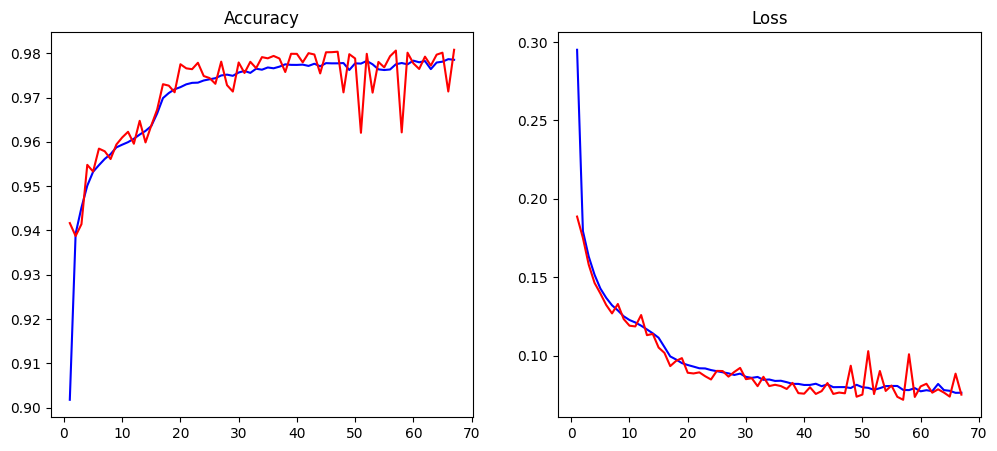

In [ ]:
plot_history(history)

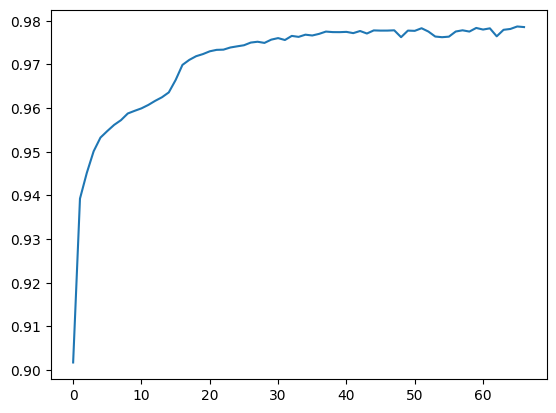

In [ ]:
pyplot.plot(history.history['accuracy'])
pyplot.savefig('DL_CNN_Accuracy_EpochVsAccuracy.jpg',dpi=900)
pyplot.show()

In [ ]:
loss, accuracy = model.evaluate(x_test_dl, y_test_dl)
print('Test Accuracy:', accuracy)

9499/9499 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9808 - loss: 0.0743
Test Accuracy: 0.9807173609733582


### 3.2.2. Model2

In [ ]:
history2 = model2.fit(x_train_dl ,y_train_dl, verbose=1, epochs=50, batch_size=256,validation_data=(x_val_dl,y_val_dl),callbacks=[early_stopping])


Epoch 1/50
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 486s 135ms/step - accuracy: 0.8065 - loss: 0.6446 - val_accuracy: 0.9323 - val_loss: 0.1925
Epoch 2/50
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 484s 136ms/step - accuracy: 0.9353 - loss: 0.1824 - val_accuracy: 0.9438 - val_loss: 0.1589
Epoch 3/50
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 486s 136ms/step - accuracy: 0.9407 - loss: 0.1653 - val_accuracy: 0.9428 - val_loss: 0.1569
Epoch 4/50
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 492s 138ms/step - accuracy: 0.9422 - loss: 0.1594 - val_accuracy: 0.9395 - val_loss: 0.1730
Epoch 5/50
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 488s 137ms/step - accuracy: 0.9450 - loss: 0.1520 - val_accuracy: 0.9099 - val_loss: 0.2357
Epoch 6/50
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 485s 136ms/step - accuracy: 0.9461 - loss: 0.1502 - val_accuracy: 0.9486 - val_loss: 0.1413
Epoch 7/50
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 484s 136ms/step - accuracy: 0.9455 - loss: 0.1546 - val_accuracy: 0.9503 - val_loss: 0.1374
Epoch 8/50
3562/3562 ━━━━━━━━━━━━━━━━━━━━ 480s 135ms/step - ac

In [ ]:
mean = sum(history.history['accuracy']) / len(history.history['accuracy'])
variance = sum([((x - mean) ** 2) for x in history.history['accuracy']]) / len(history.history['accuracy'])
res = variance ** 0.5
print("Baseline: %.2f%% (%.2f%%)" % (mean*100, res*100))

Baseline: 97.07% (1.24%)


In [ ]:
y_pred = model.predict(x_test_dl)
y_pred_class = y_pred.argmax(axis=-1)
y_test_class = np.argmax(y_test_dl, axis=1)

print(classification_report(y_test_class, y_pred_class))

9499/9499 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    100316
           1       1.00      1.00      1.00       593
           2       0.99      0.98      0.99       494
           3       0.99      1.00      0.99    158629
           4       0.89      0.27      0.41        30
           5       0.95      0.81      0.88       160
           6       0.86      0.86      0.86      4638
           7       0.96      0.93      0.94     26316
           8       0.83      0.61      0.71      2817
           9       0.89      0.96      0.93      9830
          10       0.66      0.81      0.73       129

    accuracy                           0.98    303952
   macro avg       0.91      0.84      0.86    303952
weighted avg       0.98      0.98      0.98    303952



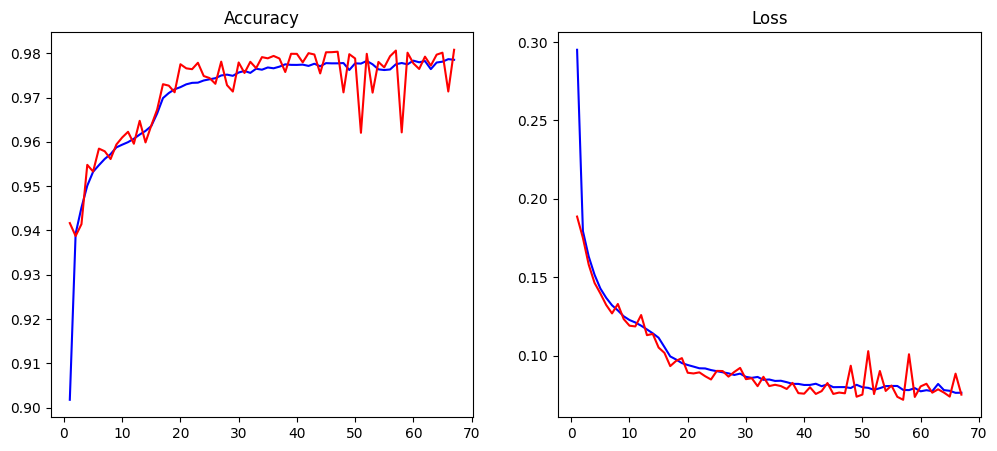

In [ ]:
plot_history(history)

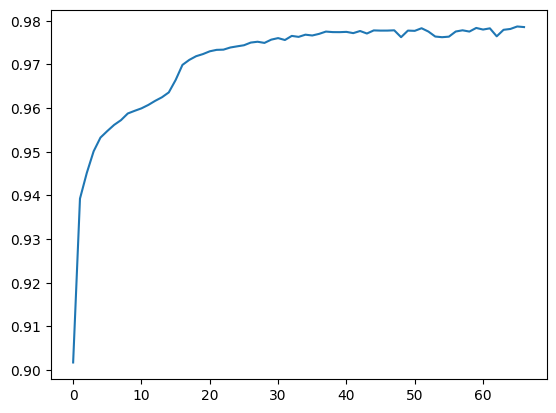

In [ ]:
pyplot.plot(history.history['accuracy'])
pyplot.savefig('DL_LSTM2_Accuracy_EpochVsAccuracy.jpg',dpi=900)
pyplot.show()

In [ ]:
loss, accuracy = model.evaluate(x_test_dl, y_test_dl)
print('Test Accuracy:', accuracy)

9499/9499 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9808 - loss: 0.0743
Test Accuracy: 0.9807173609733582
